In [160]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['figure.figsize'] = (24, 8)
mpl.rcParams['axes.grid'] = False

In [161]:
df = pd.read_csv('Cleaned_Diffusion_Chennai_30.csv')

In [162]:
df.head(5)

,DATE,05HR,06HR,07HR,08HR,09HR,10HR,11HR,12HR,13HR,14HR,15HR,16HR,17HR,18HR,19HR,20HR,Total,Season
0,1993-01-01,0.0,0.0,0.10,0.34,0.76,1.12,1.29,1.21,1.14,1.10,0.93,0.69,0.39,0.07,0.0,0.0,9.14,Rest of Year
1,1993-01-02,0.0,0.0,0.06,0.47,0.84,1.03,1.16,1.10,0.95,0.89,0.70,0.56,0.34,0.06,0.0,0.0,8.16,Rest of Year
2,1993-01-03,0.0,0.0,0.06,0.38,0.65,0.83,1.26,1.22,1.12,1.08,0.91,0.72,0.42,0.07,0.0,0.0,8.72,Rest of Year
3,1993-01-04,0.0,0.0,0.05,0.32,0.82,1.06,1.25,1.27,1.18,1.10,1.10,0.74,0.41,0.07,0.0,0.0,9.37,Rest of Year
4,1993-01-05,0.0,0.0,0.08,0.57,0.91,1.08,1.20,1.24,0.93,0.86,0.80,0.59,0.42,0.06,0.0,0.0,8.74,Rest of Year


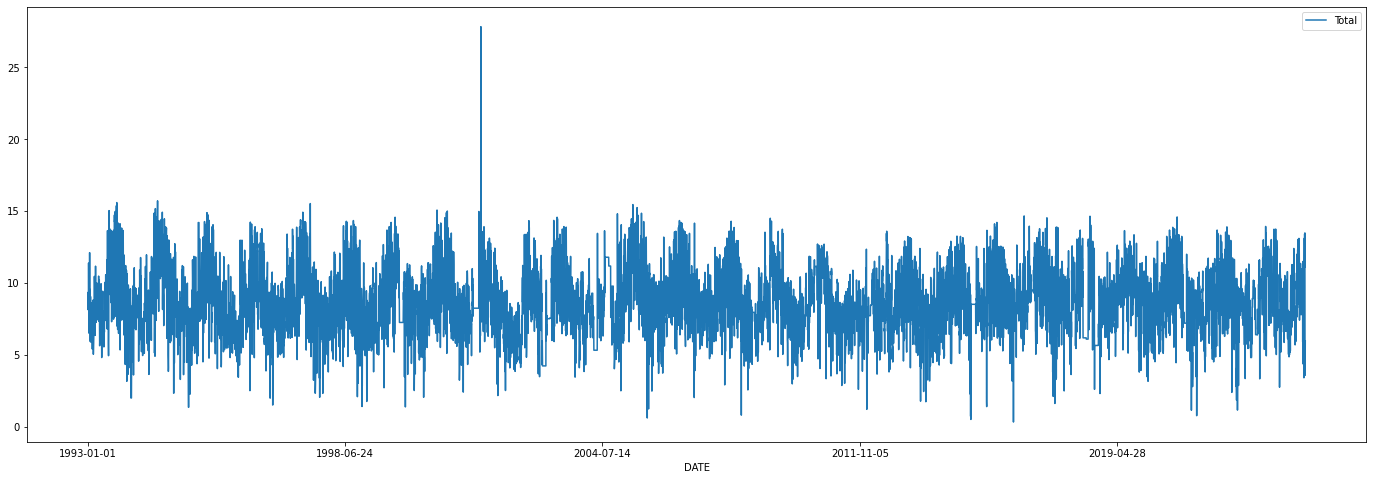

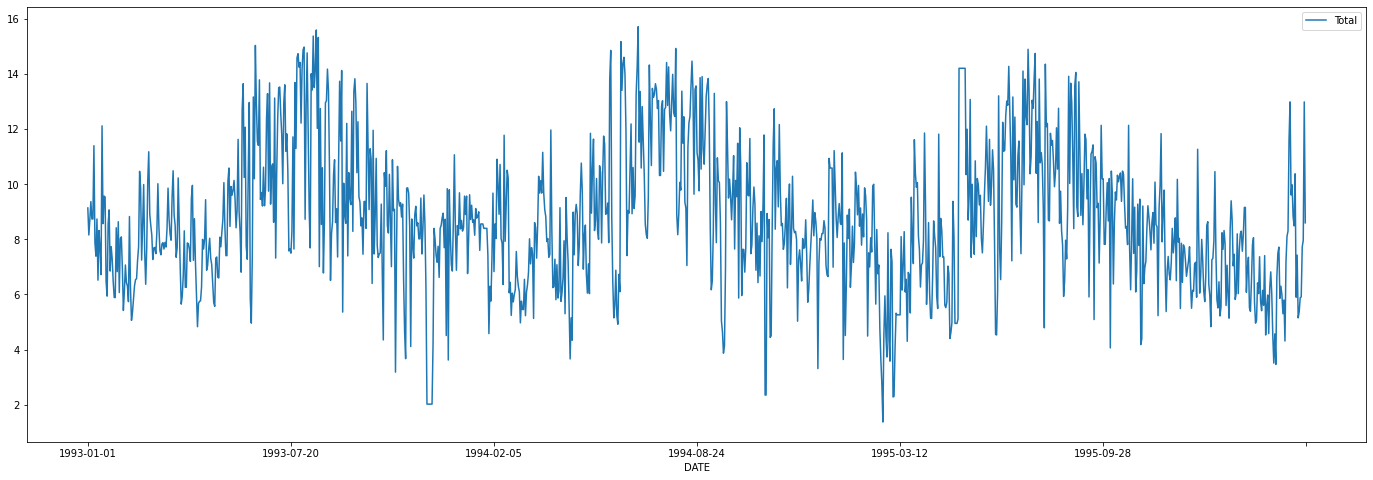

In [163]:
plot_cols = ['Total']
plot_features = df[plot_cols]
plot_features.index = df['DATE']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1200]
plot_features.index = df['DATE'][:1200]
_ = plot_features.plot(subplots=True)

In [164]:
df = df.drop(columns=['Total', 'Season','05HR','20HR'])

In [165]:
df.isnull().sum()

DATE    0
06HR    0
07HR    0
08HR    0
09HR    0
10HR    0
11HR    0
12HR    0
13HR    0
14HR    0
15HR    0
16HR    0
17HR    0
18HR    0
19HR    0
dtype: int64

In [166]:
import pandas as pd

df = df.reset_index()

hour_columns = ['06HR', '07HR', '08HR', '09HR', '10HR', '11HR', '12HR', 
                '13HR', '14HR', '15HR', '16HR', '17HR', '18HR', '19HR']

df_long = pd.DataFrame()

for hour in hour_columns:
    temp_df = df[['DATE', hour]].copy()
    temp_df['Datetime'] = pd.to_datetime(temp_df['DATE'] + ' ' + hour.replace('HR', ':00:00'), format='%Y-%m-%d %H:%M:%S')
    temp_df.rename(columns={hour: 'Radiation'}, inplace=True) 
    df_long = pd.concat([df_long, temp_df[['Datetime', 'Radiation']]], ignore_index=True)

df = df_long

df = df.sort_values(by='Datetime')
print(df.head())

                 Datetime  Radiation
0     1993-01-01 06:00:00       0.00
9463  1993-01-01 07:00:00       0.10
18926 1993-01-01 08:00:00       0.34
28389 1993-01-01 09:00:00       0.76
37852 1993-01-01 10:00:00       1.12


In [167]:
df.set_index('Datetime', inplace=True)

In [168]:
# n = len(df)
# train_df = df.iloc[:int(n*0.7)]
# val_df = df.iloc[int(n*0.7):int(n*0.9)]
# test_df = df.iloc[int(n*0.9):]

# train_mean = train_df['Radiation'].mean()
# train_std = train_df['Radiation'].std()

# train_df['Radiation'] = (train_df['Radiation'] - train_mean) / train_std
# val_df['Radiation'] = (val_df['Radiation'] - train_mean) / train_std
# test_df['Radiation'] = (test_df['Radiation'] - train_mean) / train_std

# print(train_df.head())
# print(val_df.head())
# print(test_df.head())

In [169]:
train_df

,Radiation
Datetime,
1993-01-01 06:00:00,-1.274985
1993-01-01 07:00:00,-1.068355
1993-01-01 08:00:00,-0.572443
1993-01-01 09:00:00,0.295404
1993-01-01 10:00:00,1.039273
...,...
2015-03-20 16:00:00,-0.179845
2015-03-20 17:00:00,-0.448465
2015-03-20 18:00:00,-0.903051


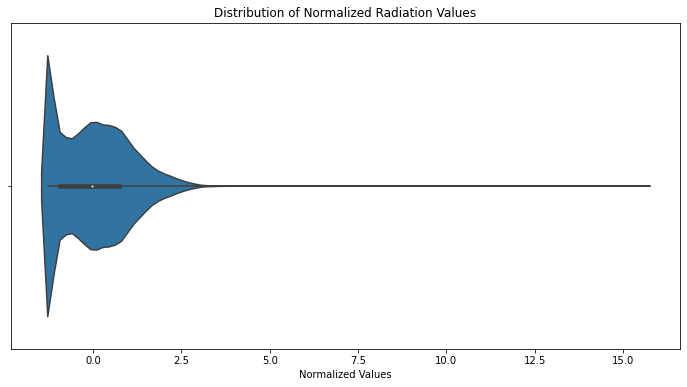

In [170]:
df['Normalized'] = (df['Radiation'] - train_mean) / train_std

# Create the violin plot directly from the normalized values
plt.figure(figsize=(12, 6))
sns.violinplot(x='Normalized', data=df)

plt.title('Distribution of Normalized Radiation Values')
plt.xlabel('Normalized Values')
plt.show()

In [171]:
train_df

,Radiation
Datetime,
1993-01-01 06:00:00,-1.274985
1993-01-01 07:00:00,-1.068355
1993-01-01 08:00:00,-0.572443
1993-01-01 09:00:00,0.295404
1993-01-01 10:00:00,1.039273
...,...
2015-03-20 16:00:00,-0.179845
2015-03-20 17:00:00,-0.448465
2015-03-20 18:00:00,-0.903051


In [172]:
def create_dataset(data, input_width, label_width):
    X, y = [], []
    for i in range(len(data) - input_width - label_width + 1):
        X.append(data[i:(i + input_width)].values)
        y.append(data[(i + input_width):(i + input_width + label_width)].values)
    return np.array(X), np.array(y)

input_width = 14  
label_width = 1   

X, y = create_dataset(df['Radiation'], input_width, label_width)


print(f'Input shape: {X.shape}')  
print(f'Label shape: {y.shape}')  

Input shape: (132468, 14)
Label shape: (132468, 1)


In [173]:
y

array([[0.  ],
       [0.06],
       [0.47],
       ...,
       [0.49],
       [0.41],
       [0.02]])

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Flatten the input for traditional ML models
X_flat = X.reshape(X.shape[0], -1)  # Reshape to (samples, input_width * features)
y_flat = y.reshape(y.shape[0], -1)   # Reshape to (samples, label_width * features)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Check predictions shape
print(f'Predictions shape: {predictions.shape}')  # Should match (samples, label_width * features)


Predictions shape: (26494, 1)


In [175]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.033160873468311314


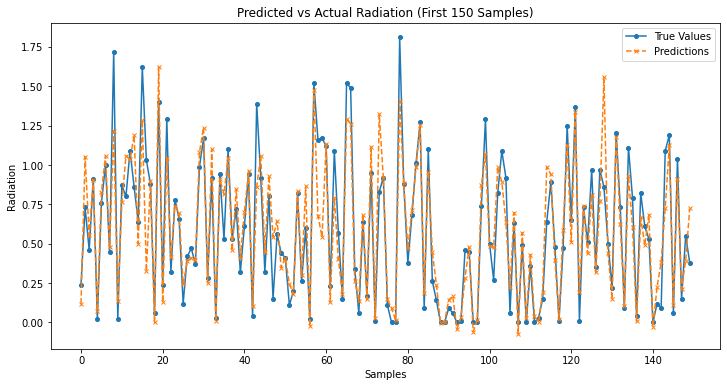

In [176]:
# Compare the first 100 predictions with actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:150], label='True Values', marker='o', markersize=4)
plt.plot(predictions[:150], label='Predictions', linestyle='--', marker='x', markersize=4)
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Radiation')
plt.title('Predicted vs Actual Radiation (First 150 Samples)')
plt.show()

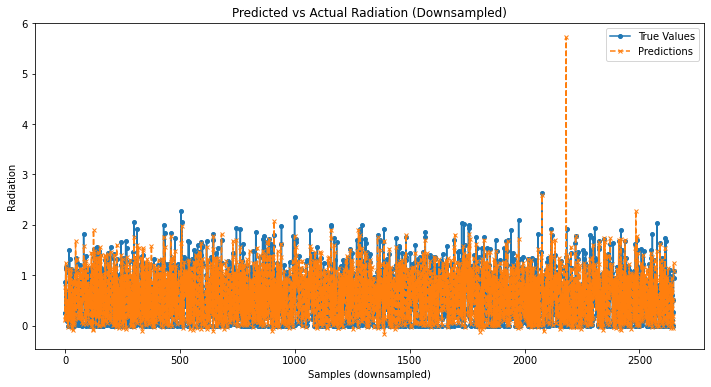

In [177]:
# Downsample by taking every 10th point for plotting
downsample_rate = 10

plt.figure(figsize=(12, 6))
plt.plot(y_test[::downsample_rate], label='True Values', marker='o', markersize=4)
plt.plot(predictions[::downsample_rate], label='Predictions', linestyle='--', marker='x', markersize=4)
plt.legend()
plt.xlabel('Samples (downsampled)')
plt.ylabel('Radiation')
plt.title('Predicted vs Actual Radiation (Downsampled)')
plt.show()
